# Transfer learning on HAM10000 Dataset using DenseNet121

### download all the files from here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
### Files are zipped to enable easy creation of dataset locally or on google colab

In [175]:
import shutil
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import glob
import tensorflow as tf
import zipfile
import os

# Shortcuts for testing purposes. 
# The first time running this notebook should have these variables set to True
unzip_files = False
train_model = False

### Test to ensure that GPU is available

In [176]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print(tf.config.list_physical_devices())

Version:  2.6.0
Eager mode:  True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [177]:
# load the metadata
df_meta = pd.read_csv('content\drive\Shareddrives\DIP\HAM10000_metadata.csv')

### Unzip and mask the images for training.

In [178]:
# Change to true on the first run to organise and preprocess the dataset
if (unzip_files):
    HAM_src = 'content\drive\Shareddrives\DIP\HAM10000_images.zip'
    localpath = 'C:/Users/aless/Documents/HAM10k/DIP/content/sample_data'
    MASK_src = 'content\drive\Shareddrives\DIP\HAM10000_segmentations_lesion_tschandl.zip'

    with zipfile.ZipFile(HAM_src, 'r') as zip_ref:
        zip_ref.extractall(localpath)

    with zipfile.ZipFile(MASK_src, 'r') as zip_ref:
        zip_ref.extractall(localpath)

    try:
      os.mkdir(f'content/')
      os.mkdir(f'content/sample_data/')
      os.mkdir(f'content/sample_data/HAM10000_Dr_images')
    except FileExistsError:
      print('directory exists')

    # segment images with lesion_tschandl masks
    def mask_images(lst):
        image = cv2.imread(f"content/sample_data/HAM10000_images/{lst}.jpg", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_dir = glob.glob(f"content/sample_data/HAM10000_segmentations_lesion_tschandl/{lst}*.png")
        masked = cv2.bitwise_and(image, cv2.imread(mask_dir[0]))
        masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"content/sample_data/HAM10000_Dr_images/{lst}.jpg", masked)

    # apply mask image function to all images
    for x in tqdm(df_meta["image_id"]):
      mask_images(x) 

    for dx in df_meta.dx.unique():
      # make directory for category if it does not exist
      try:
        os.mkdir(f'content/sample_data/HAM10000_Dr_images/{dx}')
      except FileExistsError:
        print('directory exists')

      # For all imageIDs in selected category ie dx
      category = df_meta[df_meta.dx == dx]['image_id']
      for image_id in tqdm(category):
        # Move image into correct directory
        try:
          shutil.copy(f'content/sample_data/HAM10000_Dr_images/{image_id}.jpg',f'content/sample_data/HAM10000_Dr_images/{dx}/{image_id}.jpg')
          os.remove(f'content/sample_data/HAM10000_Dr_images/{image_id}.jpg')
        except FileExistsError:
          print('file exists')
        except: 
          pass

### Create the datasets from the directories created from the zipped files above

In [179]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'content\sample_data\HAM10000_Dr_images',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(450, 600),
    shuffle=True,
    seed=999,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'content/sample_data/HAM10000_Dr_images',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(450, 600),
    shuffle=True,
    seed=999,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


### Inspect training images

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


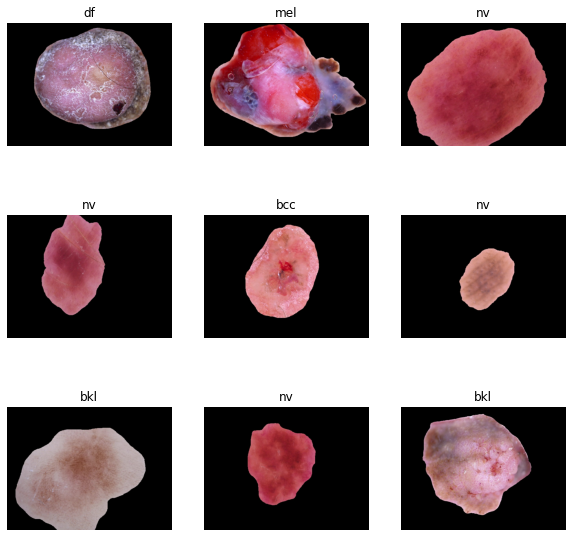

In [180]:
class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Inspect the validation images

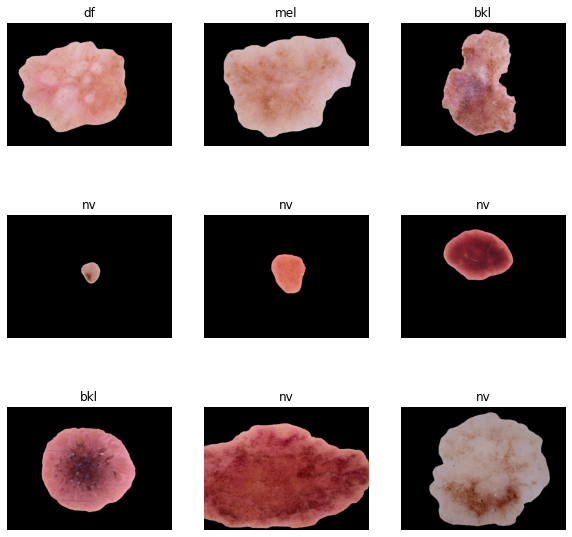

In [181]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [182]:
import itertools
class_weights = dict(zip(range(7), itertools.count(1/7, 0)))

### Train the DenseNet121 Model

In [183]:
if train_model:
    checkpoint_path = "train_DenseNet121_SparseCategoricalCrossentropy/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

    # training with densenet
    hub_layer = tf.keras.applications.DenseNet121(
        input_shape = (450, 600, 3),
        include_top=False,
        weights='imagenet')
    hub_layer.trainable = False

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape = (450, 600, 3)))
    model.add(hub_layer)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names)))

    """### Compiling model"""

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    model.summary()
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=30,
                        batch_size = 32,
                        verbose=1,
                        callbacks=[cp_callback],
                        class_weight=class_weights)


    """### Plotting graphs"""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Create confusion matrix to visualise the mistakes on the validation dataset

100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


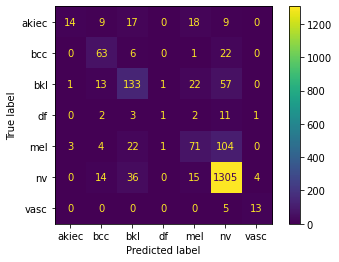

In [185]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in tqdm(val_ds):   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

### Unzip Super Pixel masks to disk
### Segment images with superpixel segmented masks

In [167]:
if(unzip_files):
    
    localpath = 'C:/Users/aless/Documents/HAM10k/DIP/content/sample_data'
    MASK_src = 'content\drive\Shareddrives\DIP\seg_masks.zip'
    with zipfile.ZipFile(MASK_src, 'r') as zip_ref:
        zip_ref.extractall(localpath)
    try: os.mkdir(f'content/sample_data/HAM_SPixel_images') 
    except:  print("HAM_SPixel_images exists")
    
    def mask_images(lst):
        image = cv2.imread(f"content/sample_data/HAM10000_images/{lst}.jpg", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_dir = glob.glob(f"content/sample_data/seg_masks/{lst}*.png")
        masked = cv2.bitwise_and(image, cv2.imread(mask_dir[0]))
        masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"content/sample_data/HAM_SPixel_images/{lst}.jpg", masked)

    for x in tqdm(df_meta["image_id"]):
        mask_images(x)

    for dx in df_meta.dx.unique():
        try:
            os.mkdir(f'content/sample_data/HAM_SPixel_images/{dx}')
        except FileExistsError:
            print('directory exists')
        category = df_meta[df_meta.dx == dx]['image_id']
        for image_id in category:
            try:
                shutil.copy(f'content/sample_data/HAM_SPixel_images/{image_id}.jpg',f'content/sample_data/HAM_SPixel_images/{dx}/{image_id}.jpg')
                os.remove(f'content/sample_data/HAM_SPixel_images/{image_id}.jpg')
            except FileExistsError:
                print('file exists')
            except: 
                pass

In [168]:
# create the superpixel dataset
s_pixel_ds = tf.keras.utils.image_dataset_from_directory(
    'content/sample_data/HAM_SPixel_images',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(450, 600),
    shuffle=True,
    seed=999,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 10015 files belonging to 7 classes.


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


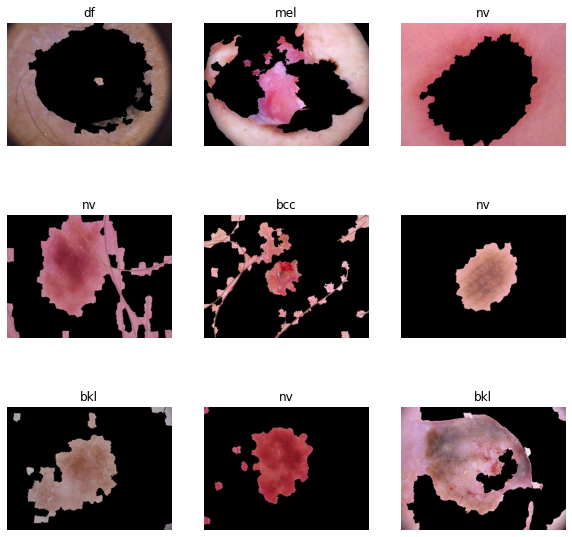

In [169]:
# display the masked images
import matplotlib.pyplot as plt

class_names = s_pixel_ds.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in s_pixel_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [170]:
checkpoint_path = "train_DenseNet121_SparseCategoricalCrossentropy/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'train_DenseNet121_SparseCategoricalCrossentropy\\cp.ckpt'

### Reload the model weights from disk and evaluate the super pixel masked images

In [171]:
# training with densenet
hub_layer = tf.keras.applications.DenseNet121(
    input_shape = (450, 600, 3),
    include_top=False,
    weights='imagenet')
hub_layer.trainable = False

"""### Creating Model"""
model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape = (450, 600, 3)))
model.add(hub_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(class_names)))

"""### Compiling model"""

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
model.load_weights(checkpoint_path)
results = model.evaluate(s_pixel_ds, batch_size=32, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 450, 600, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 14, 18, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

# Confusion Matrix
### Visualisation of the mistakes that the model is making

In [173]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in tqdm(s_pixel_ds):   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()